In [241]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs
Current working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno

In [243]:
API_keys = [
    "2b10Me1HF0rfjoGWCseolNa8e",
    "2b10Xs7brWPuBdRTSeWx9V7HJu",
    "2b10umm8L2jTYjlWrJKPfshJ0O",
    "2b10sEg5pSsrtVT372XqlrzcLe",
    "2b10LDWWlXJwuS6FleaqfK6Rke",
    "2b10BoBZKV8WqZx9XCYulKvdu",
    "2b10U9ilY13D9JvF70m7WjK1kO",
    "2b101ARTX7UKqG1hqaeL9qav",
    "2b10Aun0VZ0L3WxrRmMRtx6rsO",
    "2b10PHd7xZZfWqzPghtBrYY6Me",
    "2b10uRbRzoHPIDpZaY3ID9o4e",
    "2b104GXJh341DO2S60qo3ABkI",
]

On a 500 requêtes PlantNet par clef API chaque jour.

## Préparation des données

### sauter cette partie si les fichiers csv existent déjà dans temporary_data/plantes

A l'origine cette partie a été utilisée pour générer les datasets qui sont maintenant présents dans data/temporary_data/plantes. Ainsi, à moins de devoir recommencer de zéro, il n'est plus nécessaire d'executer ce code (mais il peut aider à comprendre le contenu des deux datasets construits).

In [268]:
# Import spipoll.csv as a pandas dataframe
spipoll = pd.read_csv("././data/spipoll.csv",low_memory=False)

# Extract relevant columns from the spipoll dataframe
plantes = spipoll[['collection_id', 'plante_sc', 'plante_fr',
       'plante_precision', 'plante_inconnue', 'plante_caractere',
       'photo_fleur', 'photo_plante', 'photo_feuille']]

# Shrinking the data by grouping by collection_id
# Keep only the first row for each unique value of collection_id
plantes = plantes.drop_duplicates(subset='collection_id', keep='first')

plantes.shape

(75372, 9)

In [269]:
values_to_check = ["Je ne sais pas", "Plante inconnue"]

In [270]:
plantes_sc_unlabelled = plantes.loc[
    (
        (plantes["plante_sc"].isna() | plantes["plante_sc"].isin(values_to_check))
    )
    | ((plantes["plante_inconnue"] == 1.0))
]

# creation du dataframe contenant les valeurs de plantes mais pas de plantes_sc_unlabelled
plantes_sc_labelled = plantes[~plantes.index.isin(plantes_sc_unlabelled.index)]

plantes_sc_labelled.shape

(63465, 9)

In [271]:
# verification des dimensions des deux df par rapport à la dim de plantes
plantes_sc_labelled.shape[0] + plantes_sc_unlabelled.shape[0] == plantes.shape[0]

True

In [272]:
plantes_precision_unlabelled = plantes_sc_unlabelled.loc[
    (
        (plantes["plante_precision"].isna() | plantes["plante_precision"].isin(values_to_check))
    )
]

# creation du dataframe contenant les valeurs de plantes_sc_unlabelled mais pas de plantes_precision_unlabelled
plantes_precision_labelled = plantes_sc_unlabelled[~plantes_sc_unlabelled.index.isin(plantes_precision_unlabelled.index)]

plantes_precision_labelled.shape

(9619, 9)

In [273]:
# verification des dimensions des deux df par rapport à la dim de plantes_sc_unlabelled
plantes_precision_labelled.shape[0] + plantes_precision_unlabelled.shape[0] == plantes_sc_unlabelled.shape[0]

True

Compression de l'information étiquettée redondante :

In [274]:
# group plantes_sc_labelled by unique values of plante_sc
plantes_sc_labelled = plantes_sc_labelled.drop_duplicates(subset='plante_sc', keep='first')

# display the dimension of the dataframe
plantes_sc_labelled.shape

(2620, 9)

In [275]:
# group plantes_precision_labelled by unique values of plante_precision
plantes_precision_labelled = plantes_precision_labelled.drop_duplicates(subset='plante_precision', keep='first')

# display the dimension of the dataframe
plantes_precision_labelled.shape

(4314, 9)

In [276]:
# ajoute trois colonnes après plante_sc dans le dataframe plantes_sc_labelled "Famille", "Genre" et "Espèce" entre la colonne plante_sc et plante_fr
plantes_sc_labelled.insert(2, "Famille", "")
plantes_sc_labelled.insert(3, "Genre", "")
plantes_sc_labelled.insert(4, "Espece", "")

# ajoute trois colonnes après plante_sc dans le dataframe plantes_precision_labelled "Famille", "Genre" et "Espèce" entre la colonne plante_sc et plante_fr
plantes_precision_labelled.insert(2, "Famille", "")
plantes_precision_labelled.insert(3, "Genre", "")
plantes_precision_labelled.insert(4, "Espece", "")

# ajoute trois colonnes après plante_sc dans le dataframe plantes_precision_unlabelled "Famille", "Genre" et "Espèce" entre la colonne plante_sc et plante_fr
plantes_precision_unlabelled.insert(2, "Famille", "")
plantes_precision_unlabelled.insert(3, "Genre", "")
plantes_precision_unlabelled.insert(4, "Espece", "")

In [278]:
plantes_precision_labelled.head()

,collection_id,plante_sc,Famille,Genre,Espece,plante_fr,plante_precision,plante_inconnue,plante_caractere,photo_fleur,photo_plante,photo_feuille
39,11,Plante inconnue,,,,NaN,Mahonia faux-houx (Berberis aquifolium),0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
78,25,Plante inconnue,,,,NaN,Camélia du Japon (Camellia japonica),0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
96,32,Plante inconnue,,,,NaN,Jasmin d'hiver (Jasminum nudiflorum),0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
168,62,Plante inconnue,,,,NaN,polygala myrtifolia,0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
175,66,Plante inconnue,,,,NaN,Alysson maritime,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...


## Appel à l'API

In [279]:
from data_quality.plant_treatment.plantnet_api import PlantNetPredictor

def call_API(df, iloc, api_key_index=0):
    
    predictor = PlantNetPredictor(key = API_keys[api_key_index])
    prediction = None

    try:
        prediction = predictor.predict(imageURL= df['photo_fleur'].iloc[iloc],
                        organs = "auto",
                        includeRelatedImages=False)
    except Exception as e:
        if api_key_index + 1 < len(API_keys):
            return call_API(df, iloc, api_key_index + 1)
        else:
            print(f"Error: {e}")
            return ["erreur_API", "erreur_API", "erreur_API"]

    try:
        famille = prediction["results"][0]["species"]["family"]["scientificNameWithoutAuthor"] # famille
        genre = prediction["results"][0]["species"]["genus"]["scientificNameWithoutAuthor"] # genre
        espece = prediction["results"][0]["species"]["scientificNameWithoutAuthor"] # espece
    
    except IndexError:
        print("IndexError: list index out of range")
        return ["erreur_API", "erreur_API", "erreur_API"]

    return [famille, genre, espece]

In [280]:
def remplir_tableau(df, num):
    
    for i in tqdm(range(num)):
        start_index = 0

        for j, val in enumerate(df["Famille"]):
            if val == "":
                start_index = j
                break
        else:
            print("Le dataframe est déjà rempli.")
            return df

        try:
            df.iloc[start_index, 2:5] = call_API(df,start_index)
        except Exception as e:
            print(f"Error: {e}")

    return df

### Un petit POC (pas nécessaire pour la suite)

### sauter cette partie si les fichiers csv existent déjà dans temporary_data/plantes

In [ ]:
remplir_tableau(plantes_sc_labelled, 7)

In [ ]:
plantes_sc_labelled.head(15) # verification des 7 premières lignes remplies et 3 suivantes non remplies

In [ ]:
# (uniquement utile pour faire des tests) vide les colonnes "Famille", "Genre" et "Espece" du dataframe plantes_sc_labelled
plantes_sc_labelled.iloc[:, 2:5] = ""

In [ ]:
plantes_sc_labelled.shape # verification du maintien de la dimension du dataframe : OK

## Pipeline

Il faut environ 3 secondes pour un call API, soit environ 2h10 pour les 2620 plantes à traiter dans plantes_sc_labelled.

On va donc stocker le dataframe dans un csv entre chaque appel à l'API pour ne pas perdre le travail effectué.

In [281]:
def save_dataframe(df, df_name):
    df.to_csv(f"data/temporary_data/plantes/{df_name}.csv", index=False)

In [282]:
def import_dataframe(df_name):
    return pd.read_csv(f"data/temporary_data/plantes/{df_name}.csv")

In [284]:
plantes_sc_labelled = import_dataframe("plantes_sc_labelled")
plantes_precision_labelled = import_dataframe("plantes_precision_labelled")
plantes_precision_unlabelled = import_dataframe("plantes_precision_unlabelled")

In [285]:
def pipeline_remplissage(df_name, num):
    df = import_dataframe(df_name)
    df[["Famille", "Genre", "Espece"]] = df[["Famille", "Genre", "Espece"]].fillna("")
    remplir_tableau(df, num)
    save_dataframe(df, df_name)

In [ ]:
# POC
# pipeline_remplissage("plantes_precision_labelled", 10)

### Sauvegarde progressive des calls API

In [219]:
def pipeline(df_name, n):
    for i in range(n):
        try:
            pipeline_remplissage(df_name, 10) # une itération prend 30 secondes
        except Exception as e:
            print(f"Error occurred after {i} successful runs: {e}")
            break   

permet d'effectuer une sauvegarde des telechargements toutes les 10 occurences ie toutes les 30 secondes

In [307]:
pipeline('plantes_precision_labelled', 87)

 10%|█         | 1/10 [00:00<00:05,  1.61it/s]

IndexError: list index out of range


 20%|██        | 2/10 [00:05<00:24,  3.11s/it]

Error: Error 400 while predicting image https://spgp-api.65mo.fr/api/containers/spgp/download/128335258412833545715.gif


 20%|██        | 2/10 [00:07<00:26,  3.29s/it]

IndexError: list index out of range


 80%|████████  | 8/10 [00:26<00:05,  2.82s/it]

IndexError: list index out of range


 20%|██        | 2/10 [00:08<00:30,  3.87s/it]

### Verification de la progression des téléchargements

In [224]:
def verification_progression(df_name):
    # importe le dataframe plantes_sc_labelled depuis le fichier csv
    df = pd.read_csv(f"data/temporary_data/plantes/{df_name}.csv")
    # utilise missingno pour visualiser les valeurs manquantes dans le dataframe
    msno.matrix(df)
    
    # estimation de la quantité de travail restante en téléchargement de données
    num_nan = df["Famille"].isna().sum()
    percent_nan = round((num_nan / len(df)) * 100,2)
    print("\n")
    print(f"Nombre de lignes dans 'Famille' restants à télécharger : {num_nan}")
    print(f"Pourcentage de lignes dans 'Famille' restants à télécharger : {percent_nan} %")

In [300]:
# importe plantes_precision_labelled depuis le fichier csv
plantes_precision_labelled = import_dataframe("plantes_precision_labelled")
# toutes les lignes de famille genre espece conteant "erreur_API" doivent être vidées avec ""
plantes_precision_labelled[["Famille", "Genre", "Espece"]] = plantes_precision_labelled[["Famille", "Genre", "Espece"]].replace("erreur_API", "")
# sauvegarde le dataprecisioname dans un fichier csv
save_dataframe(plantes_precision_labelled, "plantes_precision_labelled")




Nombre de lignes dans 'Famille' restants à télécharger : 870
Pourcentage de lignes dans 'Famille' restants à télécharger : 20.17 %


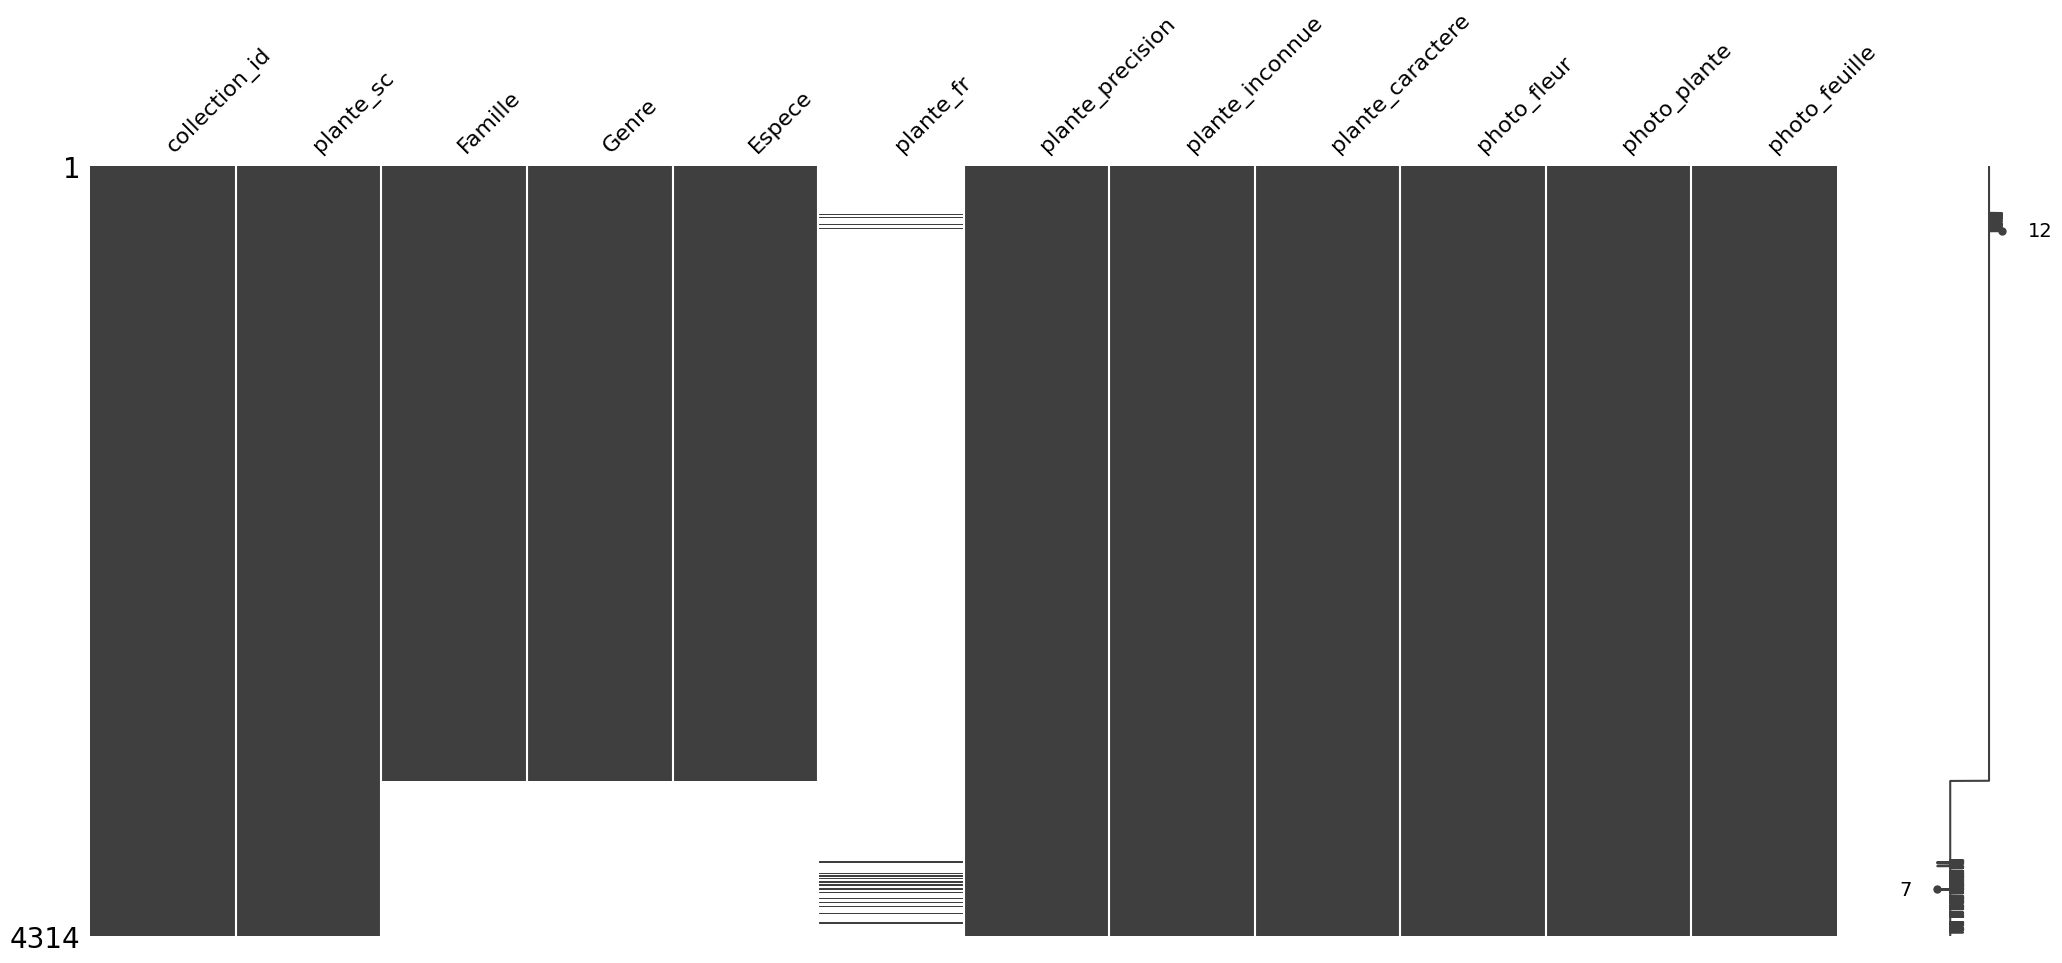

In [306]:
verification_progression('plantes_precision_labelled')

## Export des résultats

In [239]:
def export_plantes(nom_df):
    # Importer le dataframe
    df = pd.read_csv(f"data/temporary_data/plantes/{nom_df}.csv")

    # Vérifier si la colonne "Famille" contient des valeurs NaN
    if df["Famille"].isna().any():
        num_nan = df["Famille"].isna().sum()
        percent_nan = round((num_nan / len(df)) * 100,2)
        print("Il reste", percent_nan,"% des données à télécharger, soit", num_nan,"lignes.")
        msno.matrix(df)
    else:
        # Sauvegarder le dataframe dans un fichier CSV
        df.to_csv(f"data/plantes/{nom_df}.csv", index=False)

In [240]:
export_plantes('plantes_precision_labelled')

## Décompression des données

In [ ]:
# to do : quand les 3 dataframes seront telechargées à 100 % 